In [ ]:
# import libraries
import os
import csv
import cv2
import shutil
import pandas as pd
import numpy as np
from PIL import Image
from google.colab.patches import cv2_imshow

# Data processing 
1. resize the image 
2. split data into page-level and frame-level 

In [ ]:
def preprocess_page(dir_path, width, height, output_dir):
  # Loop through all files in the input directory
  for filename in os.listdir(dir_path):
    # Get the full path of the file
    filepath = os.path.join(dir_path, filename)
    # Check if the file is an image
    if os.path.isfile(filepath) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
      # Load the image
      img = Image.open(filepath)
      # Resize the image to the desired dimensions
      img = img.resize((width, height))
      # Convert the image to grayscale
      img = img.convert('L')
      # Save the resized image to the output directory
      img.save(os.path.join(output_dir, filename))
  return output_dir

In [ ]:
def frame_extraction(input_dir, output_dir):
    
    # Loop through all images in the input directory
    for img_filename in os.listdir(input_dir):
        # Load the image
        img = cv2.imread(os.path.join(input_dir, img_filename))
        
        # Apply Canny edge detection
        edges = cv2.Canny(img, 50, 150, apertureSize=3)
        
        # Find contours in the edges image
        contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        # Loop over the contours and filter out the ones that are not frames
        frames = set()
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w > 700 and h > 800: # adjust the minimum width and height to filter out small contours
                aspect_ratio = float(w)/h
                if aspect_ratio > 0.3 and aspect_ratio < 3.0: # adjust the aspect ratio range to filter out non-frame contours
                    frame=(x, y, w, h)
                    if frame not in frames:
                        frames.add(frame)
                        
        # Crop the image to the bounding boxes to extract the frames
        for i, frame in enumerate(frames):
            x, y, w, h = frame
            frame_img = img[y:y+h, x:x+w]
            filename = f'{img_filename.split(".")[0]}_frame_{i}.jpg' # Add the image filename to the frame filename
            cv2.imwrite(os.path.join(output_dir, filename), frame_img)
            
    return output_dir

In [ ]:
width = 1600
height = 2000

# Set the input directories
dir_path = 'Comics'

# create empty folder for resized page level images
output_dir = 'resize'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# create empty folder for pre-processed panel level images
frame_dir = 'frame'
if not os.path.exists(frame_dir):
    os.makedirs(frame_dir)

In [ ]:
output_dir=preprocess_page(dir_path, width, height, output_dir)

In [ ]:
frame_dir =frame_extraction(output_dir, frame_dir)

# OCR

In [ ]:
# installation 
!pip install paddlepaddle==2.4.1 -i https://pypi.tuna.tsinghua.edu.cn/simple
import paddle
paddle.utils.run_check()
!pip install "paddleocr>=2.0.1" 
!pip install nltk
from paddleocr import PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang="en")

In [ ]:
def OCR (frame):
  frame = Image.open(frame)
  all_texts = []
  img_np = np.array(frame)
  text = ocr.ocr(img_np, cls=True)
  new_result=text[0]
  texts = [line[1][0] for line in new_result]
  all_texts.extend(texts)
  sentence=' '.join(all_texts)

  return sentence

In [ ]:
import logging

# Disable debug messages from ppocr logger
logging.getLogger('ppocr').setLevel(logging.WARNING)

# Text Entity (TE) retrieval

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 100.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.9 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
import torch

ner_pipeline = pipeline("ner", model="dbmdz/electra-large-discriminator-finetuned-conll03-english", tokenizer="dbmdz/electra-large-discriminator-finetuned-conll03-english")

In [2]:
def TE2_1(sentence):
    '''
    apply Named Entity Recognition (NER) and select entity with the label "I-MISC" only
    '''
    named_ents = ner_pipeline(sentence)

    filtered_list = []
    i = 0
    while i < len(named_ents):
        if named_ents[i]['score'] > 0.8 and named_ents[i]['entity'] == 'I-MISC':
            word = named_ents[i]['word']
            i += 1
            while i < len(named_ents) and named_ents[i]['index'] == named_ents[i-1]['index'] + 1:
                word += '' + named_ents[i]['word']
                i += 1
            word = word.replace('##', '')  # remove special characters
            #filtered_list.append(word.title())
            filtered_list.append(word)
        else:
            i += 1
    
    return filtered_list

# CLIP-based 
input image and TEs, and return the image with keywords 

In [ ]:
# # CLIP-based 
from transformers import CLIPProcessor, CLIPModel

In [ ]:
def clip_based(image_path):
    # Load the CLIP model and processor
    model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

    # Load the image
    image = Image.open(image_path)
    sentence = OCR(image_path) 
    TE = TE2_1(sentence)

    # Preprocess the inputs
    inputs = processor(text=TE, images=image, return_tensors="pt", padding=True)
    outputs = model(**inputs)

    # Run the model and calculate the probabilities
    if outputs is not None:
      probs = outputs.logits_per_image.softmax(dim=1)[0]

    # Create a dictionary containing the text and its corresponding probabilities
    label_probs_dict = {}
    for i in range(len(TE)):
        label_probs_dict[TE[i]] = float(probs[i])
    
    # Filter out scores lower than 0.7 and sort the dictionary based on score
    # label_probs_dict = {k: v for k, v in label_probs_dict.items() if v > 0.7}
    label_probs_dict = dict(sorted(label_probs_dict.items(), key=lambda x: x[1], reverse=True))

    return label_probs_dict


In [ ]:
def clip_based_new(image_path, TE):
    # Load the CLIP model and processor
    model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

    # Load the image
    image = Image.open(image_path)

    # Preprocess the inputs
    inputs = processor(text=TE, images=image, return_tensors="pt", padding=True)
    outputs = model(**inputs)

    # Run the model and calculate the probabilities
    if outputs is not None:
      probs = outputs.logits_per_image.softmax(dim=1)[0]

    # Create a dictionary containing the text and its corresponding probabilities
    label_probs_dict = {}
    for i in range(len(TE)):
        label_probs_dict[TE[i]] = float(probs[i])
    
    # Filter out scores lower than 0.7 and sort the dictionary based on score
    #label_probs_dict = {k: v for k, v in label_probs_dict.items() if v > 0.7} # without threshold 
    label_probs_dict = dict(sorted(label_probs_dict.items(), key=lambda x: x[1], reverse=True))

    return label_probs_dict

In [ ]:
clip_based_new('frame/p19_frame_1_1.jpg', ['Dronier','FW.190','German'])

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


{'FW.190': 0.5012344121932983,
 'Dronier': 0.4958060383796692,
 'German': 0.002959489356726408}

In [ ]:
clip_based_new('frame/Catalina.jpg', ['Catalina','Walrus'])

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


{'Catalina': 0.8470040559768677, 'Walrus': 0.15299592912197113}

In [ ]:
clip_based_new('frame/Walrus.jpg', ['Catalina','Walrus'])

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


{'Catalina': 0.8059450387954712, 'Walrus': 0.1940550059080124}

CLIP cannot make a precise identification of the aircraft type. For example, it cannot distinguish a Walrus aircraft from a Catalina aircraft. Both will be classified as Catalina as shown above. 

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Apply the CLIP model to image folders

In [ ]:
def process_images_in_folder(folder_path, output_file):
    # Define a dictionary to store the results
    results_dict = {}

    # Loop through all the files in the directory
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Apply the clip_based function to the image
            filepath = os.path.join(folder_path, filename)
            label_probs_dict = clip_based(filepath)

            # Extract the text with highest probability from the dictionary
            if label_probs_dict:
                text = list(label_probs_dict.keys())[0]
                # Add the result to the dictionary
                results_dict[filename] = text

    # Create a Pandas dataframe from the dictionary and sort it by file name
    df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["result"])
    df.index.name = "filename"
    df.sort_index(inplace=True)

    # Save the DataFrame as a CSV file
    with open(output_file, 'w') as f:
        df.to_csv(f, index=False)
    
    return df

In [ ]:
# fine-tuning 

# Crop image (optional)
Use the previously created csv file to extract the box coordinates for each identified image and then crop the image based on these coordinates. The reason for cropping the image is to accurately identify the keyword attached to each object, rather than the image as a whole.

The following procedures are to generate the cropped image. We can apply the "Crop" folder to "process_images_in_folder" to get the results for the cropped image. Note that the TE extraction needs to be changed accordingly. 

In [ ]:
def add_bbox_column(csv_filename):
    with open(csv_filename, 'r') as csv_file:
        reader = csv.reader(csv_file)
        header = next(reader)
        header.append('bbox')
        rows = []
        for row in reader:
            bbox = []
            for dictionary in eval(row[1]):
                if 'bbox' in dictionary:
                    bbox.append(dictionary['bbox'])
            row.append(str(bbox))  # convert bbox list to string
            rows.append(row)
    with open(csv_filename, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(header)
        writer.writerows(rows)


In [ ]:
add_bbox_column('TE1.csv')

In [ ]:
# Open the input CSV file and create a new output CSV file
with open('TE1.csv', 'r') as infile, open('TE1_crop.csv', 'w', newline='') as outfile:
    reader = csv.reader(infile)
    writer = csv.writer(outfile)

    # Iterate over each row in the input file
    for row in reader:
        # Remove the second and third columns (index 1 and 2) from each row
        del row[1:3]
        # Write the modified row to the output file
        writer.writerow(row)


In [ ]:
def crop_images_from_csv(csv_filename, image_folder, output_folder, output_csv_filename):
    # Make sure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    with open(csv_filename, 'r') as csv_file, open(output_csv_filename, 'w', newline='') as output_csv:
        reader = csv.reader(csv_file)
        writer = csv.writer(output_csv)
        header = next(reader)
        header.append('cropped_image_filename')
        header.append('cropped_image_coordinates')
        writer.writerow(header)
        for row in reader:
            # Get the image file path and bounding boxes
            img_path = os.path.join(image_folder, row[0])
            bboxes = eval(row[1])

            # Open the image
            img = Image.open(img_path)

            # Crop the image for each bounding box
            for i, bbox in enumerate(bboxes):
                left, top, right, bottom = bbox
                cropped_img = img.crop((left, top, right, bottom))

                # Save the cropped image to the output folder
                cropped_filename = os.path.splitext(row[0])[0] + f'_{i}.jpg'
                cropped_path = os.path.join(output_folder, cropped_filename)
                cropped_img.save(cropped_path)

                # Write the cropped image filename and coordinates to the output CSV
                cropped_coords = f'({left}, {top}, {right}, {bottom})'
                cropped_row = row + [cropped_filename, cropped_coords]
                writer.writerow(cropped_row)

    print(f"Cropped images saved to {output_folder}")

In [ ]:
crop_images_from_csv("TE1_crop.csv","frame", "Crop", "crop.csv")

Cropped images saved to Crop


In [ ]:
# !rm -rf Crop

# Blur (optional)
Blur is there to minimise the effect of text on the CLIP model. 

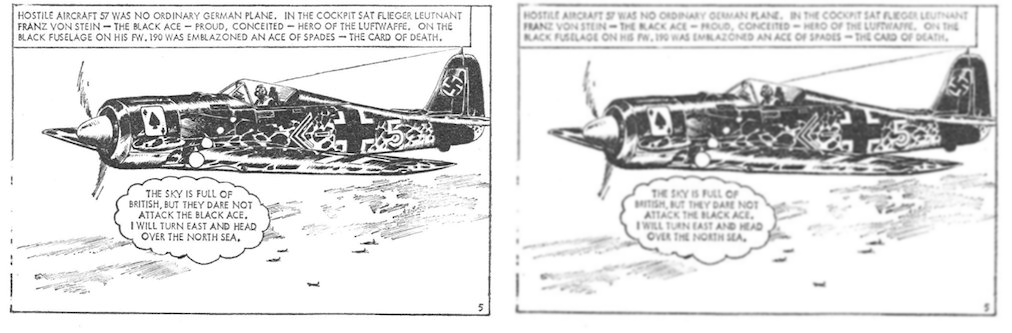

In [ ]:
# Load an image
img = cv2.imread('frame/p05-1.jpg')


# Apply Gaussian blur
blurred = cv2.GaussianBlur(img, (5,5), 0)

# Display the original and blurred images side by side
side_by_side = np.hstack((img, blurred))
cv2_imshow(side_by_side)
cv2.waitKey(0)
cv2.destroyAllWindows()